### Will Yadier Molina be inducted into the MLB Hall of Fame?
This code is intended to use machine learning techniques in order to provide an answer to this controversial question. Will Yadier Molina be inducted into Cooperstown Hall of Fame?
The samples of data selected (the players) will have the following requirements
The same position as Yadier Molina (C), 
Appeared in the Hall of Fame Database.

### Databases
https://github.com/chadwickbureau/baseballdatabank/tree/master/core

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use(plt.style.available[14])
sns.set()

In [2]:
# Simulation parameters
PEOPLE_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/People.csv'
BATTING_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv'
FIELDING_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Fielding.csv'
APPEARENCES_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Appearances.csv'
AWARDS_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/contrib/AwardsPlayers.csv'
HOF_DB_ADDRESS = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/contrib/HallOfFame.csv'
DF_STATS_COLUMNS = ['playerID', 'nameFirst', 'nameLast', 'birthYear','birthCountry', 'G_c', 'G_all', 'AB', 'R', 'RBI', 'H', '2B', '3B', 'HR', 'AVG', 'PB', 'SB', 'inducted']
MIN_G_C = 50

In [3]:
# Read data bases
people_df = pd.read_csv(PEOPLE_DB_ADDRESS)
batting_df = pd.read_csv(BATTING_DB_ADDRESS)
fielding_df = pd.read_csv(FIELDING_DB_ADDRESS)
appearances_df = pd.read_csv(APPEARENCES_DB_ADDRESS)
awards_df = pd.read_csv(AWARDS_DB_ADDRESS)
hof_df = pd.read_csv(HOF_DB_ADDRESS)

In [4]:
# Create an empty data frame with the columns to be populated for our model
stats_df = pd.DataFrame(columns = DF_STATS_COLUMNS)
stats_df.head()

,playerID,nameFirst,nameLast,birthYear,birthCountry,G_c,G_all,AB,R,RBI,H,2B,3B,HR,AVG,PB,SB,inducted


### We need to select players with a particular number of games played as a catcher. 
### Lets check some data about the players that have played at least 1, 10 and 20 games as a catcher


In [5]:
# Mean games played as catcher for all the players that have played at least 1, 10, 20 games as a catcher in a given season
mean_games_as_c_1 = appearances_df.loc[appearances_df['G_c']>=1, 'G_c'].mean()
mean_games_as_c_10 = appearances_df.loc[appearances_df['G_c']>=10, 'G_c'].mean()
mean_games_as_c_20 = appearances_df.loc[appearances_df['G_c']>=20, 'G_c'].mean()
print(str(mean_games_as_c_1) + ', mean games for catchers with more than 1 game as catcher\n' + 
      str(mean_games_as_c_10) + ', mean games for catchers with more than 10 game as catcher\n' + 
      str(mean_games_as_c_20) + ', mean games for catchers with more than 20 game as catcher\n ')
# Given this information the minimum games as catcher is 50 (check simulation parameters MIN_G_C)

43.187901861252115, mean games for catchers with more than 1 game as catcher
58.59557699094224, mean games for catchers with more than 10 game as catcher
67.29800393590104, mean games for catchers with more than 20 game as catcher
 


In [6]:
# Obtain the playerID of the players that played more than the minimum games as catchers
# selected in the simulation parameters. This data frame will contain duplicates.
catchers_ID_MIN_G_c_duplicates = appearances_df.loc[appearances_df['G_c']>MIN_G_C, 'playerID'].sort_values().reset_index(drop=True)

In [7]:
# Check the data retrieved with the indexes reset
catchers_ID_MIN_G_c_duplicates.head()

0    abbotfr01
1    adamsbe01
2    adamsbe01
3    agnewsa01
4    agnewsa01
Name: playerID, dtype: object

In [8]:
# Drop the duplicates
catchers_ID_MIN_G_c = catchers_ID_MIN_G_c_duplicates.drop_duplicates().reset_index(drop=True)

In [9]:
# Retrieve only the players with a minimum games played as catcher and at the same time they were candidates to the hall of fame
stats_df['playerID'] = catchers_ID_MIN_G_c[catchers_ID_MIN_G_c.isin(hof_df['playerID'])].reset_index(drop=True)

In [10]:
# Populate the data frame with the information of the selected players
# First people information (People database)
stats_df['nameFirst'] = people_df.nameFirst.loc[people_df['playerID'].isin(stats_df['playerID'])].reset_index(drop=True)
stats_df['nameLast'] = people_df.nameLast.loc[people_df['playerID'].isin(stats_df['playerID'])].reset_index(drop=True)
stats_df['birthYear'] = people_df.birthYear.loc[people_df['playerID'].isin(stats_df['playerID'])].reset_index(drop=True)
stats_df['birthCountry'] = people_df.birthCountry.loc[people_df['playerID'].isin(stats_df['playerID'])].reset_index(drop=True)
stats_df['inducted'] = hof_df.playerID.loc[hof_df['inducted'] == 'Y'].isin(stats_df['playerID']).reset_index(drop=True)

In [11]:
# Populate the data frame with the information of the selected players
# In this part are populated stats that require the sum of all the year of a particular player
# i represents every player in our list of catchers
stats_array = np.zeros(stats_df.shape)
for i in np.arange(stats_array.shape[0]):
    stats_array[i, 5] = appearances_df.G_c.loc[appearances_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 6] = appearances_df.G_all.loc[appearances_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 7] = batting_df.AB.loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 8] = batting_df.R.loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 9] = batting_df.RBI.loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 10] = batting_df.H.loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 11] = batting_df['2B'].loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 12] = batting_df['3B'].loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 13] = batting_df.HR.loc[batting_df['playerID'] == stats_df.playerID[i]].sum()
    # AVG is computed in the next section
    stats_array[i, 15] = fielding_df.PB.loc[fielding_df['playerID'] == stats_df.playerID[i]].sum()
    stats_array[i, 16] = fielding_df.SB.loc[fielding_df['playerID'] == stats_df.playerID[i]].sum()
    # inducted is crosschecked in the next section
    
    

In [12]:
# Populate the stats_df with the array obtained in the last section
stats_df['G_c'] = stats_array[:, 5]
stats_df['G_all'] = stats_array[:, 6]
stats_df['AB'] = stats_array[:, 7]
stats_df['R'] = stats_array[:, 8]
stats_df['RBI'] = stats_array[:, 9]
stats_df['H'] = stats_array[:, 10]
stats_df['2B'] = stats_array[:, 11]
stats_df['3B'] = stats_array[:, 12]
stats_df['HR'] = stats_array[:, 13]
stats_df['AVG'] = stats_df['H']/stats_df['AB']
stats_df['PB'] = stats_array[:, 15]
stats_df['SB'] = stats_array[:, 16]

In [13]:
# Populte the stats_df with the most important feature. Was the player inducted into the hall of fame?
stats_df['inducted'] = stats_df['playerID'].isin(hof_df.playerID.loc[hof_df['inducted'] == 'Y']).reset_index(drop=True)

In [14]:
# This is the number of catchers inducted into the hall of fame
stats_df['inducted'].sum()

24

In [15]:
# These are the numbers of the inducted players (24 catchers)
stats_df.loc[stats_df['inducted']]

,playerID,nameFirst,nameLast,birthYear,birthCountry,G_c,G_all,AB,R,RBI,H,2B,3B,HR,AVG,PB,SB,inducted
5,benchjo01,Johnny,Bench,1947.0,USA,1743.0,2158.0,7658.0,1091.0,1376.0,2048.0,381.0,24.0,389.0,0.267433,94.0,610.0,True
9,berrayo01,Yogi,Berra,1925.0,USA,1695.0,2120.0,7555.0,1175.0,1430.0,2150.0,321.0,49.0,358.0,0.284580,76.0,208.0,True
11,biggicr01,Craig,Biggio,1965.0,USA,428.0,2850.0,10876.0,1844.0,1175.0,3060.0,668.0,55.0,291.0,0.281353,32.0,434.0,True
14,bresnro01,Roger,Bresnahan,1879.0,USA,972.0,1447.0,4481.0,682.0,530.0,1252.0,218.0,71.0,26.0,0.279402,129.0,614.0,True
16,camparo01,Roy,Campanella,1921.0,USA,1182.0,1215.0,4205.0,627.0,856.0,1161.0,178.0,18.0,242.0,0.276100,56.0,85.0,True
19,cartega01,Gary,Carter,1954.0,USA,2056.0,2296.0,7971.0,1025.0,1225.0,2092.0,371.0,31.0,324.0,0.262451,84.0,1498.0,True
21,chancfr01,Frank,Chance,1876.0,USA,188.0,1290.0,4299.0,798.0,596.0,1274.0,200.0,79.0,20.0,0.296348,30.0,205.0,True
22,cochrmi01,Mickey,Cochrane,1903.0,USA,1449.0,1482.0,5169.0,1041.0,832.0,1652.0,333.0,64.0,119.0,0.319598,88.0,0.0,True
32,dickebi01,Bill,Dickey,1907.0,USA,1704.0,1789.0,6300.0,930.0,1209.0,1969.0,343.0,72.0,202.0,0.312540,76.0,0.0,True
36,ewingbu01,Buck,Ewing,1859.0,USA,636.0,1315.0,5363.0,1129.0,883.0,1625.0,250.0,178.0,71.0,0.303002,360.0,239.0,True


In [16]:
# Check the players. These will be all the sample players (116 catchers)
stats_df.head()

,playerID,nameFirst,nameLast,birthYear,birthCountry,G_c,G_all,AB,R,RBI,H,2B,3B,HR,AVG,PB,SB,inducted
0,allisdo01,Doug,Allison,1846.0,USA,277.0,316.0,1407.0,236.0,139.0,382.0,44.0,10.0,2.0,0.271500,166.0,0.0,False
1,alomasa02,Sandy,Alomar,1966.0,P.R.,1324.0,1377.0,4530.0,520.0,588.0,1236.0,249.0,10.0,112.0,0.272848,71.0,758.0,False
2,archeji01,Jimmy,Archer,1883.0,Ireland,734.0,850.0,2646.0,246.0,296.0,660.0,106.0,34.0,16.0,0.249433,70.0,124.0,False
3,ausmubr01,Brad,Ausmus,1969.0,USA,1938.0,1971.0,6279.0,718.0,607.0,1579.0,270.0,34.0,80.0,0.251473,61.0,894.0,False
4,bartobo01,Bob,Barton,1941.0,USA,380.0,393.0,1049.0,54.0,66.0,237.0,31.0,3.0,9.0,0.225929,9.0,181.0,False


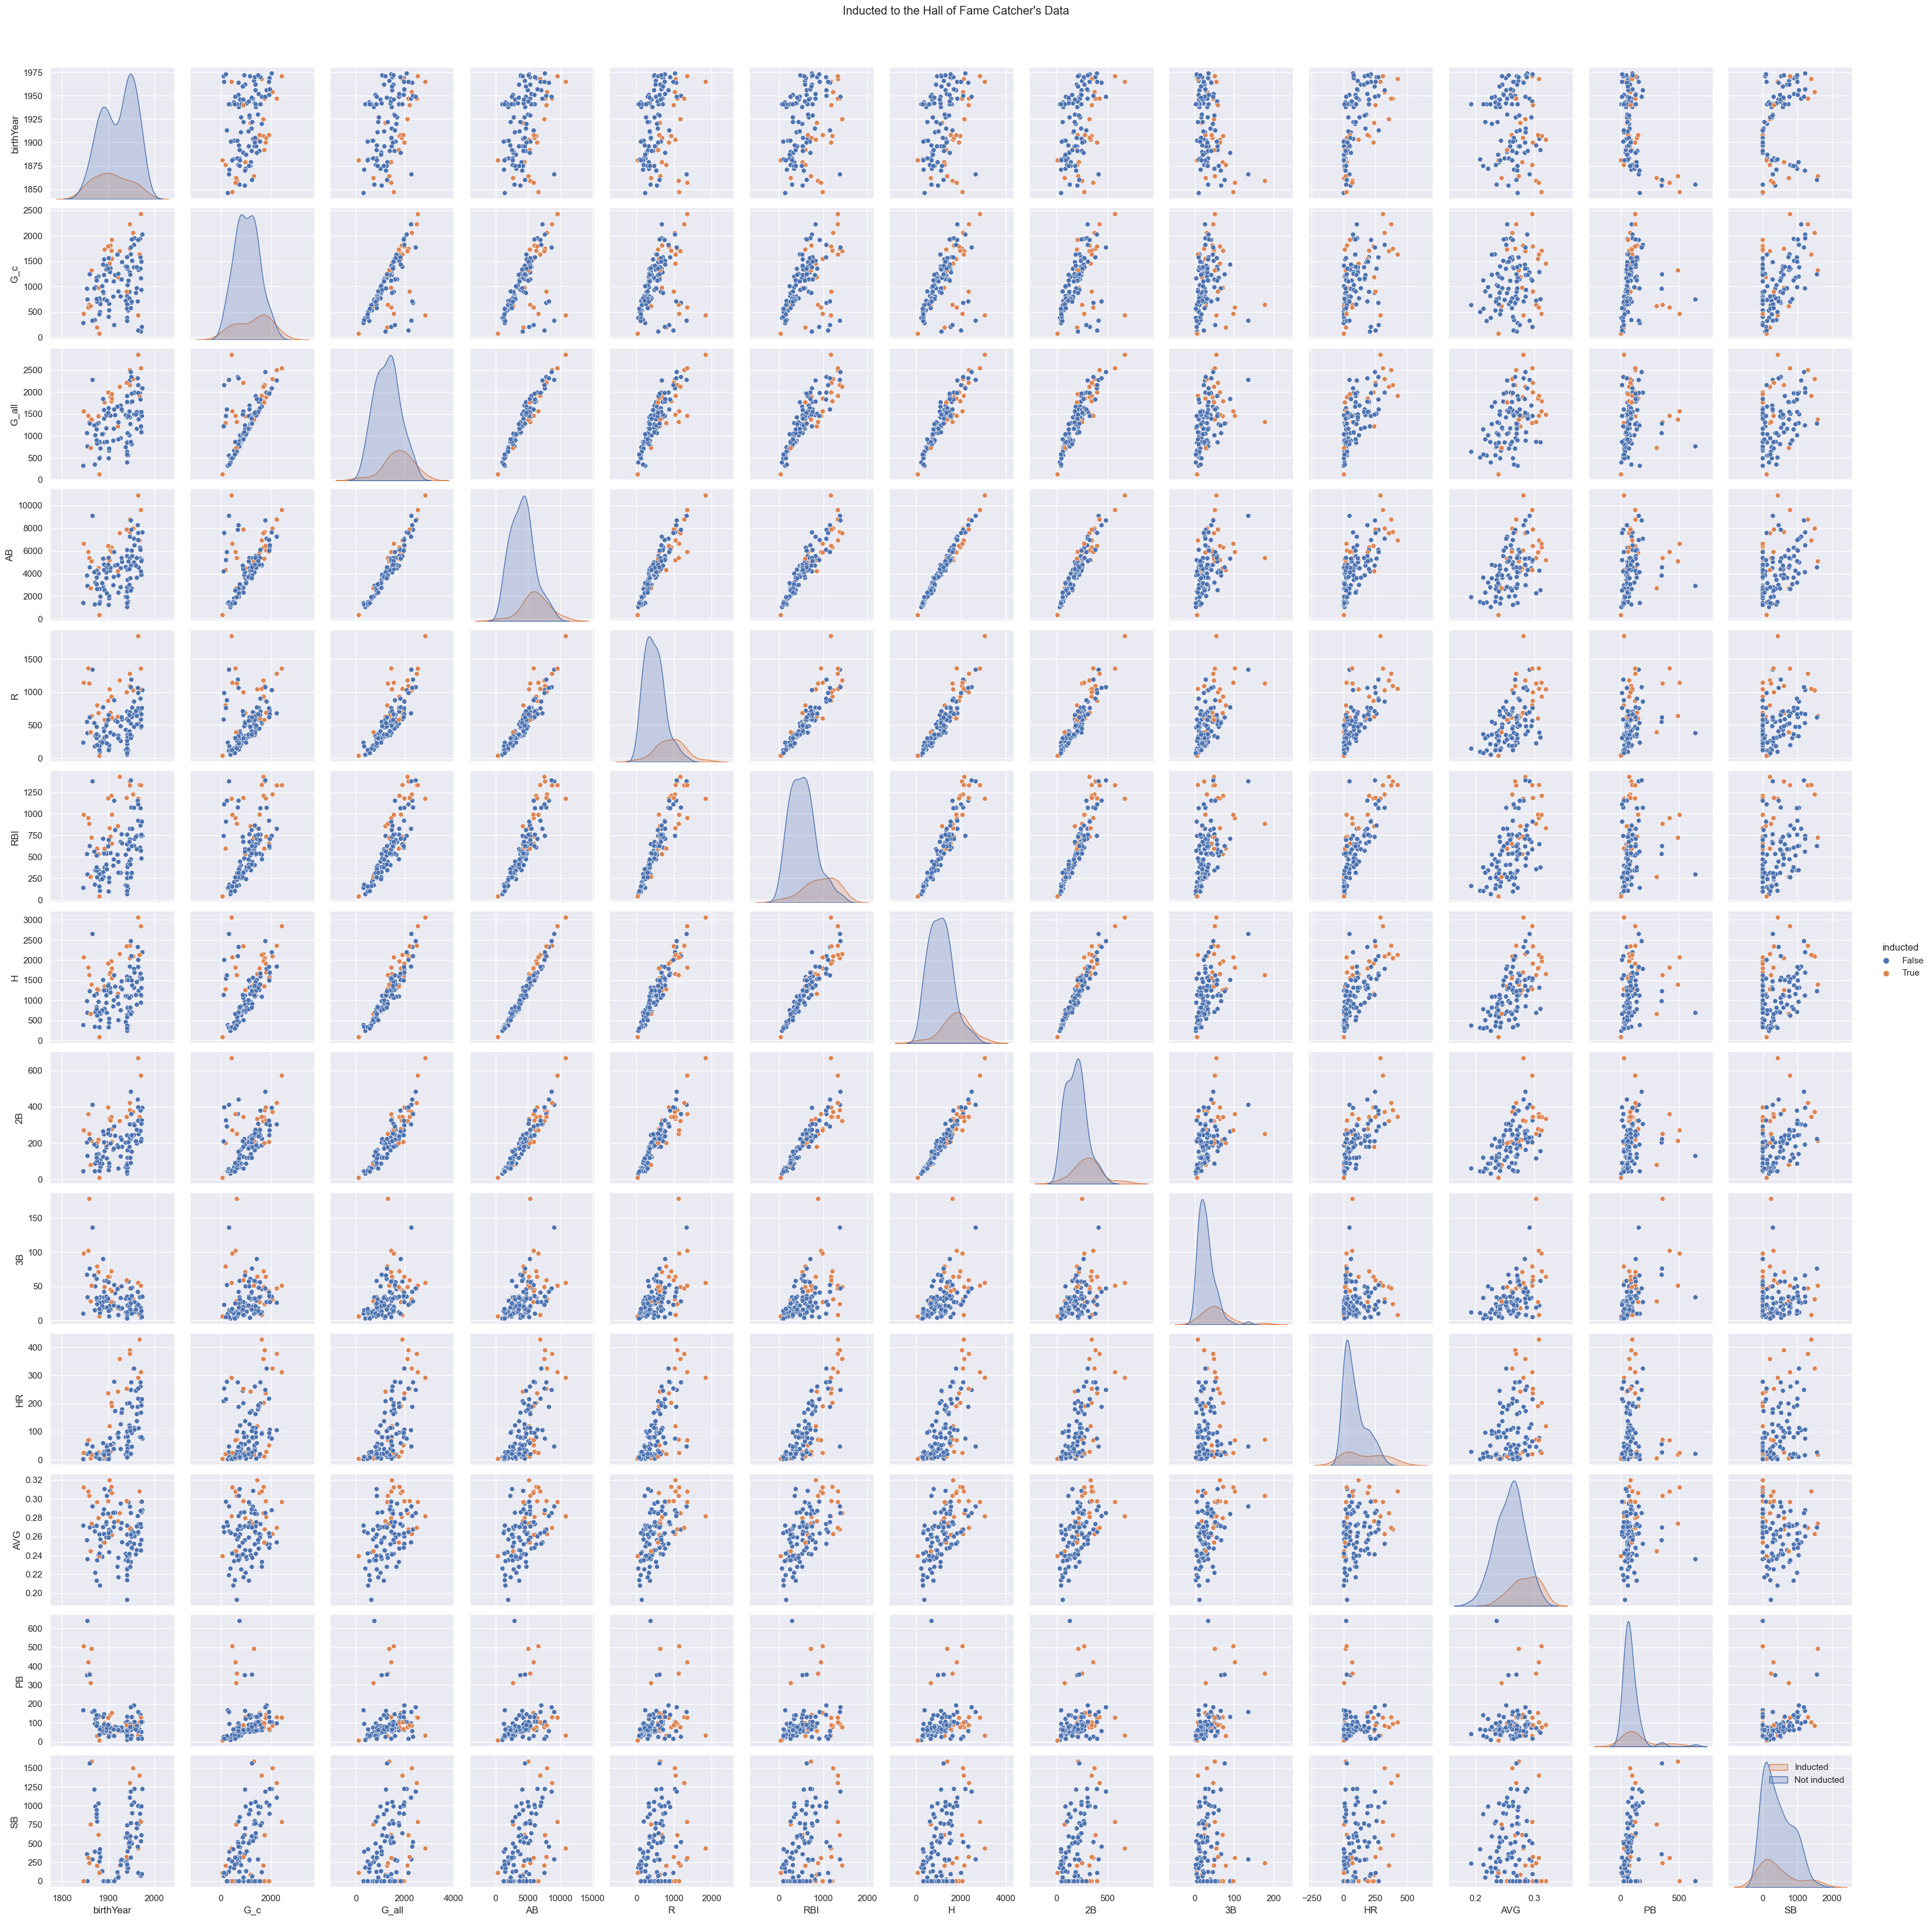

In [17]:
# Graph the data to reveal association between parameters
sns_plot = sns.pairplot(stats_df, hue='inducted');
plt.suptitle('Inducted to the Hall of Fame Catcher\'s Data', y=1.02)
plt.legend(['Inducted', 'Not inducted'])

In [18]:
# Save image to disk (commented to upload to GitHub)
# sns_plot.figure.savefig(PATH)

In [19]:
# Allocate in the analysis df the numerical data
X = stats_df.drop(['playerID', 'nameFirst', 'nameLast', 'birthYear','birthCountry', 'inducted'], axis=1)
y = stats_df['inducted']

In [20]:
# Select the model
model = GaussianNB()

In [21]:
# Create a training and test sets with the train tests split function
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

In [22]:
# Fit to data
model.fit(Xtrain, ytrain)

GaussianNB()

In [23]:
# Get the predictions according to the model
y_model = model.predict(Xtest)

In [24]:
# Visually compare the real values (ytest) with the predicted values (y_model) 
# Some predictions did not match the real value
comparison = pd.DataFrame({'ytest': ytest, 'y_model': y_model})
comparison

,ytest,y_model
95,False,False
44,False,False
56,False,False
97,False,False
69,False,False
114,False,True
73,False,False
58,True,False
35,False,False
38,True,False


In [25]:
# Obtain an accuracy score of the model 82%
accuracy_score(ytest, y_model)

0.8275862068965517

In [26]:
# Input Yadier Molina's data to the model.(Baseball Reference 2022)
# This is a manual input with the numbers updated to sep-21-2022
molinaDict = [{'G_c':2180 ,
              'G_all':2221,
              'AB':7806,
              'R':777,
              'RBI':1020,
              'H':2167,
              '2B':408,
              '3B':7,
              'HR':176,
              'AVG':278,
              'PB':96,
              'SB':562}]
molina = pd.DataFrame(molinaDict)
molina

,G_c,G_all,AB,R,RBI,H,2B,3B,HR,AVG,PB,SB
0,2180,2221,7806,777,1020,2167,408,7,176,278,96,562


In [32]:
# The moment of the truth. Will Yadier Molina be inucted to the hall of fame?
model.predict(molina)

array([False])

## False

# Yadier Molina will not be inducted into the Hall of Fame

Come back to try this model again when Yadier Molina retires.